# Assignment 1 2AMM10 2023-2024

## Group: [Fill in your group name]
### Member 1: [Fill in your name]
### Member 2: [Fill in your name]
### Member 3: [Fill in your name]

In [74]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle

In [75]:
# function for loading the training data:

def load_data(file):
    """
    This function loads the data from the specified pickle file and returns a dictionary with the data
    :param filename: the pickle file
    :return: dict with data -- keys and values differ for the train data and test data for each task.
     Please see the cells with example code below for explanations and examples of the data structure per data set.
    """
    with open(file, 'rb') as f:
        data_dict = pickle.load(f)
    return data_dict

train_data = load_data('data/a1/train_data.pkl')

In [76]:
# the structure of the training data is a dict, where the keys are strings indicating the alphabet.
# The values are again dicts, with the keys being the character and the values being a list of images of that character.

# see the code below for examples of working with the train data

alphabets = list(train_data.keys())


print('example alphabet names:', alphabets[:5])
print('\n')
print('how to get an example image for a specific character:')

alphabet_id = 4
alphabet = alphabets[alphabet_id]  # a dict
characters_for_this_alphabet = list(train_data[alphabet].keys())
character_id = 5
character = characters_for_this_alphabet[character_id]
image_id = 2

print(f'shape of image {image_id} of character {character} of alphabet {alphabet}:', train_data[alphabet][character][image_id].shape)

example alphabet names: ['Alphabet_of_the_Magi', 'Anglo-Saxon_Futhorc', 'Arcadian', 'Armenian', 'Asomtavruli_(Georgian)']


how to get an example image for a specific character:
shape of image 2 of character character06 of alphabet Asomtavruli_(Georgian): torch.Size([1, 105, 105])


In [77]:
# function for plotting some examples:

def plot_example_data(data_dict):
    """
    This function plots some examples of the data
    :param data_dict: dict with as keys a string specifying the alphabet, and as values a dict with as keys the character of the alphabet, and as values a list om images of the alphabet
    """
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    alphabets_to_plot = np.random.choice(list(data_dict.keys()), size=10, replace=False)

    for i, alphabet in enumerate(alphabets_to_plot):
        characters = data_dict[alphabet]
        character_to_plot = np.random.choice(list(characters.keys()), size=1)[0]
        images = characters[character_to_plot]
        im_idx = np.random.choice(len(images), size=1)[0]
        axs[i//5, i%5].imshow(images[im_idx].permute(1, 2, 0))
        axs[i//5, i%5].set_title(alphabet + '\n' + character_to_plot, fontsize=8)
        axs[i//5, i%5].axis('off')
    # plt.show()


<Figure size 640x480 with 0 Axes>

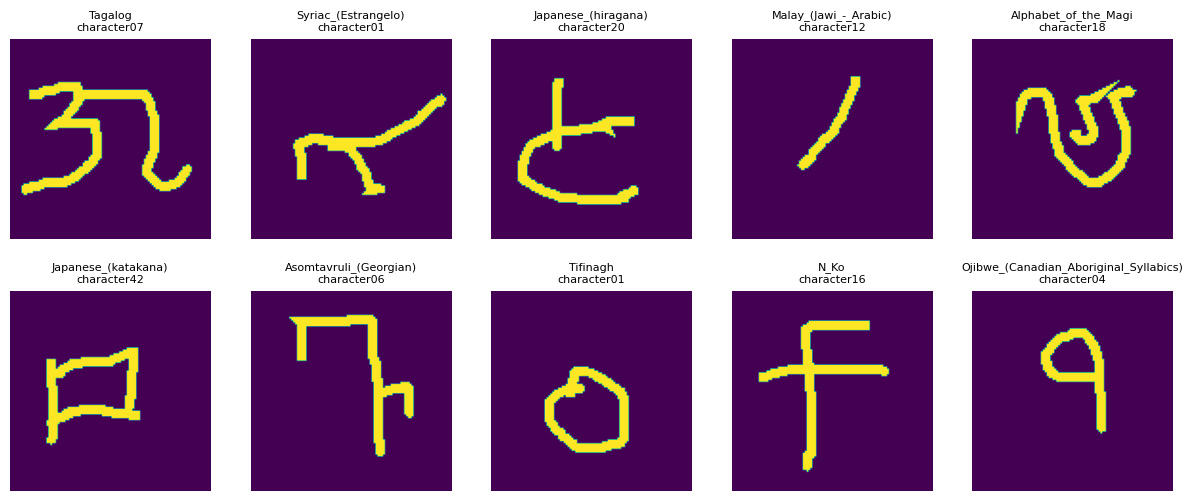

In [78]:
plt.figure()
plot_example_data(train_data)
# plt.savefig('example_data.png', dpi=600)
plt.show()

# Task 1: character recognition

In [79]:
# our solution:
import pandas as pd

# print(train_data['Alphabet_of_the_Magi']['character01'])
# print(len(train_data['Alphabet_of_the_Magi']['character01']))

df_tobe = []
for alphabet in train_data.keys():
    for key in train_data[alphabet].keys():
        for image in train_data[alphabet][key]:
            df_tobe.append((alphabet + '_' + key, image))
train_data_df = pd.DataFrame(data=df_tobe)

# train_data_df = pd.DataFrame(data=((alphabet + '_' + key, image) for image in train_data[alphabet][key] for key in train_data[alphabet].keys() for alphabet in train_data.keys()))
# print(train_data_df[0])
# print(np.array(train_data_df[1][0]).shape)

In [80]:
print(train_data.keys())

# random seed
random_seed = 42

from sklearn.model_selection import train_test_split
# split dataset into training set and validation set
train_size = 0.8  # 80:20 split

inputs_train, inputs_valid = train_test_split(
    train_data_df[1],
    random_state=random_seed,
    train_size=train_size,
    shuffle=True)

targets_train, targets_valid = train_test_split(
    train_data_df[0],
    random_state=random_seed,
    train_size=train_size,
    shuffle=True)

# for alphabet in train_data.keys():
#     for character in train_data[alphabet].keys():
#         print(len(train_data[alphabet][character]))

dict_keys(['Alphabet_of_the_Magi', 'Anglo-Saxon_Futhorc', 'Arcadian', 'Armenian', 'Asomtavruli_(Georgian)', 'Balinese', 'Bengali', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Braille', 'Burmese_(Myanmar)', 'Cyrillic', 'Early_Aramaic', 'Futurama', 'Grantha', 'Greek', 'Gujarati', 'Hebrew', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Japanese_(hiragana)', 'Japanese_(katakana)', 'Korean', 'Latin', 'Malay_(Jawi_-_Arabic)', 'Mkhedruli_(Georgian)', 'N_Ko', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Sanskrit', 'Syriac_(Estrangelo)', 'Tagalog', 'Tifinagh'])


In [81]:
label_to_idx_train = {k: v for v, k in enumerate(train_data_df[0].unique())}
idx_to_label_train = {v: k for v, k in enumerate(train_data_df[0].unique())}

inputs_train = inputs_train.values
inputs_valid = inputs_valid.values

targets_train = np.array([label_to_idx_train[label] for label in targets_train])
targets_valid = np.array([label_to_idx_train[label] for label in targets_valid])

In [82]:
# Datasets and Dataloaders
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data.sampler import BatchSampler
from itertools import combinations


class CustomImageDataset(Dataset):
    def __init__(self, inputs: list, targets: list, transform=None, target_transform=None):
        self.inputs = inputs
        self.targets = targets
        self.transform = transform
        self.target_transform = target_transform
        self.classes = label_to_idx_train.keys()

        self.inputs_dtype = torch.float32
        self.targets_dtype = torch.long

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index: int):

        input_id = self.inputs[index]
        target_id = self.targets[index]

        x = self.inputs[index]
        y = self.targets[index]

        # Load input and target
        #x=Image.open(input_id)
        #y=Image.open(target_id)

        # Preprocessing
        if self.transform is not None:
            x=self.transform(x).type(self.inputs_dtype)

        return x, y

class BalancedBatchSampler(BatchSampler):
    """
    Returns batches of size n_classes * n_samples
    """

    def __init__(self, labels, n_classes, n_samples):
        self.labels = labels

        # unique_labels = np.unique(np.array(self.labels))
        # self.labels_set = unique_labels.tolist()
        self.labels_set = list(set(self.labels))
        self.label_to_indices = {label: np.where(np.array(self.labels) == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.n_dataset = len(self.labels)
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < self.n_dataset:
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return self.n_dataset // self.batch_size


class RandomTripletSelector():
    """
    Select random negative  example for  each positive pair  to create triplets
    """

    def __init__(self):
        super(RandomTripletSelector, self).__init__()

    def get_triplets(self, embeddings, labels):
        labels = labels.cpu().data.numpy()
        triplets = []
        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs

            # random choose one negative example for each positive pair
            temp_triplets = [[anchor_positive[0], anchor_positive[1], np.random.choice(negative_indices)] for anchor_positive in anchor_positives]
            triplets += temp_triplets

        return torch.LongTensor(np.array(triplets))

In [83]:
import torchvision.transforms as transforms
from torchvision.transforms import Compose, ToTensor, Resize

image_size = (32,32)

DATA_TRANSFORM = transforms.Compose([
    transforms.Resize(image_size),
    # transforms.ToTensor(),
    ])

train_dataset = CustomImageDataset(inputs=inputs_train[:10000], targets=targets_train[:10000], transform=DATA_TRANSFORM)
val_dataset = CustomImageDataset(inputs=inputs_valid[:1000], targets=targets_valid[:1000], transform=DATA_TRANSFORM)

train_batch_sampler = BalancedBatchSampler(train_dataset.targets, n_classes=20, n_samples=5)
test_batch_sampler = BalancedBatchSampler(val_dataset.targets, n_classes=20, n_samples=5)

triplets_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler)
triplets_val_loader = torch.utils.data.DataLoader(val_dataset, batch_sampler=test_batch_sampler)

# Model

In [84]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

class EmbeddingNet(nn.Module):
    def __init__(self, embedding_size=40):
        """CNN Builder."""
        super(EmbeddingNet, self).__init__()

        self.embedding_size = embedding_size

        self.front_layer = nn.Sequential(
            # Conv Layer block 1
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),


            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            Lambda(lambda x: x.view(x.size(0), -1)),

            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
        )

        self.last_layer = nn.Linear(512, self.embedding_size)

    def forward(self, x):
        """Perform forward."""
        # conv layers
        x = self.front_layer(x)
        x = self.last_layer(x)
        return x

    def get_embedding(self, x):
        return self.forward(x)

class TripletLoss(nn.Module):
    """
    Triplets loss
    Takes a batch of embeddings and corresponding labels.
    Triplets are generated using triplet_selector object that take embeddings and targets and return indices of
    triplets
    """

    def __init__(self, margin, triplet_selector):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.triplet_selector = triplet_selector

    def forward(self, embeddings, target):

        triplets = self.triplet_selector.get_triplets(embeddings, target)

        if embeddings.is_cuda:
            triplets = triplets.cuda()

        anchor_idx= triplets[:, 0]
        positive_idx= triplets[:, 1]
        negative_idx= triplets[:, 2]


        ap_distances = (embeddings[anchor_idx] - embeddings[positive_idx]).pow(2).sum(1)  # .pow(.5)
        an_distances = (embeddings[anchor_idx] - embeddings[negative_idx]).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(ap_distances - an_distances + self.margin)

        return losses.mean()

# Training

In [85]:
import numpy as np
from tqdm import tqdm


class Trainer():
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset ,
                 epochs: int
                 ):

        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.device = device
        self.epochs = epochs




    def run_trainer(self):


        for epoch in tqdm(range(self.epochs)):



            self.model.train()  # train mode

            train_losses=[]
            for batch in self.training_DataLoader:

                x,y=batch
                input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)
                self.optimizer.zero_grad()  # zerograd the parameters
                out = self.model(input)  # one forward pass
                loss = self.criterion(out, target)  # calculate loss

                loss_value = loss.item()
                train_losses.append(loss_value)

                loss.backward()  # one backward pass
                self.optimizer.step()  # update the parameters



            self.model.eval()  # evaluation mode
            valid_losses = []  # accumulate the losses here

            for batch in self.validation_DataLoader:

                x,y=batch
                input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)

                with torch.no_grad():
                    out = self.model(input)   # one forward pass
                    loss = self.criterion(out, target) # calculate loss

                    loss_value = loss.item()
                    valid_losses.append(loss_value)



            # print the results
            print(
                f'EPOCH: {epoch+1:0>{len(str(self.epochs))}}/{self.epochs}',
                end=' '
            )
            print(f'LOSS: {np.mean(train_losses):.4f}',end=' ')
            print(f'VAL-LOSS: {np.mean(valid_losses):.4f}',end='\n')

In [86]:
# device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')

# model
embedding_net = EmbeddingNet()
model = embedding_net.to(device)


# margin value
margin=1

# criterion
criterion = TripletLoss(margin,  RandomTripletSelector())

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# trainer
trainer = Trainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=triplets_train_loader,
                  validation_DataLoader=triplets_val_loader,
                  epochs=10)

# start training
trainer.run_trainer()

 10%|█         | 1/10 [00:40<06:02, 40.23s/it]

EPOCH: 01/10 LOSS: 0.7807 VAL-LOSS: 0.3820


 20%|██        | 2/10 [01:25<05:44, 43.10s/it]

EPOCH: 02/10 LOSS: 0.3032 VAL-LOSS: 0.2792


 30%|███       | 3/10 [02:08<05:02, 43.15s/it]

EPOCH: 03/10 LOSS: 0.2243 VAL-LOSS: 0.1245


 40%|████      | 4/10 [02:51<04:17, 42.93s/it]

EPOCH: 04/10 LOSS: 0.1604 VAL-LOSS: 0.1451


 50%|█████     | 5/10 [03:34<03:36, 43.25s/it]

EPOCH: 05/10 LOSS: 0.1136 VAL-LOSS: 0.2453


 60%|██████    | 6/10 [04:17<02:52, 43.01s/it]

EPOCH: 06/10 LOSS: 0.0916 VAL-LOSS: 0.1115


 70%|███████   | 7/10 [04:58<02:07, 42.43s/it]

EPOCH: 07/10 LOSS: 0.0698 VAL-LOSS: 0.0880


 80%|████████  | 8/10 [05:40<01:24, 42.14s/it]

EPOCH: 08/10 LOSS: 0.0595 VAL-LOSS: 0.1239


 90%|█████████ | 9/10 [06:23<00:42, 42.36s/it]

EPOCH: 09/10 LOSS: 0.0550 VAL-LOSS: 0.0495


100%|██████████| 10/10 [07:04<00:00, 42.48s/it]

EPOCH: 10/10 LOSS: 0.0471 VAL-LOSS: 0.1786


# Evaluation

**ACCURACY**

In [87]:
def extract_embeddings(dataloader, model):

    cuda = torch.cuda.is_available()
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), model.embedding_size))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

In [88]:
class CharacterMatcher:
    def __init__(self, model: EmbeddingNet, transform):
        self.model = model
        self.transform = transform
    

    def fit(self, alphabet, alphabet_labels):
        label_to_idx_alphabet = {label: idx for idx, label in enumerate(alphabet_labels)}
        alphabet_targets = np.array([label_to_idx_alphabet[label] for label in alphabet_labels])

        alphabet_dataset = CustomImageDataset(inputs=alphabet, targets=alphabet_targets, transform=self.transform)
        alphabet_loader = torch.utils.data.DataLoader(alphabet_dataset, batch_size=256)
        
        self.alphabet_embeddings, _ = extract_embeddings(alphabet_loader, self.model)
        self.labels = alphabet_labels
    

    def get_matches(self, image, k=1):
        if len(self.labels) == 0:
            print("character matcher must be fitted before matching")
            return

        with torch.no_grad():
            if torch.cuda.is_available():
                image = image.cuda()
            model.eval()
            image = self.transform(image[None,None,]).type(torch.float32)
            unseen_embedding = model.get_embedding(image).data.cpu().numpy()
        
        distances = [np.linalg.norm(embedding - unseen_embedding) for embedding in self.alphabet_embeddings]
        distance_sort = np.argsort(distances)
        return np.array(self.labels.copy())[distance_sort][:k].tolist()

In [89]:
def get_accuracy(model, data_dict_test, k=1):
    matcher = CharacterMatcher(model, DATA_TRANSFORM)
    total = 0
    correct = 0

    alphabets = list(data_dict_test['annotated_images'].keys())
    for alphabet_id in tqdm(alphabets):
    
        alphabet_annotated = data_dict_test['annotated_images'][alphabet_id]
        alphabet_annotated_labels = data_dict_test['annotated_images_labels'][alphabet_id]
        alphabet_unseen = data_dict_test['unseen_images'][alphabet_id]
        alphabet_unseen_labels = data_dict_test['unseen_images_labels'][alphabet_id]

        matcher.fit(alphabet_annotated, alphabet_annotated_labels)

        for idx, character in enumerate(alphabet_unseen):
            label = alphabet_unseen_labels[idx]

            for image in character:
        
                k_closest_labels = matcher.get_matches(image, k)

                #assess
                if label in k_closest_labels:
                    correct += 1
                total += 1

    return correct / total

data_dict_test_task1 = load_data('data/a1/test_data_task1.pkl')

accuracy = get_accuracy(model, data_dict_test_task1, k=8)
print("total accuracy:", round(accuracy, 4))

100%|██████████| 20/20 [01:07<00:00,  3.36s/it]

total accuracy: 0.8899


# Task 2: rotation problem

In [ ]:
# load the test data for task 2:
# the structure of the test data of task 2 is exactly the same as for task 1,
# but now the images are rotated by an unknown angle between 0 and 360 degrees.
data_dict_test_task2 = load_data('test_data_task2.pkl')

In [ ]:
data_dict_test_task2.keys()

In [ ]:
# solution and evaluation of task 2:

# Task 3: Domain knowledge injection

In [ ]:
# load the test data for task 3:
# the structure of the data of task 3 is exactly the same as for task 1, but now our the loaded dictionary contains some additional keys.
# These additional keys will be explained in the cells below:

data_dict_test_task3 = load_data('test_data_task3.pkl')
print(data_dict_test_task3.keys())

In [ ]:
# The keys 'annotated_images', 'annotated_images_labels', 'unseen_images', 'unseen_images_labels' are the same as for task 1, and the structure of the data is exactly the same.

# The key 'unseen_images_preceding_types' maps to the type of the preceding character in the sequence where the unseen image was observed, for each alphabet.
# The key 'character_to_type_mapping' maps to the mapping of each character to its type, for each alphabet.
# The key 'type_following_probs' maps to the probabilities of each character type being followed by another character type, for each alphabet.

In [ ]:
# examples:

alphabet = np.random.choice(list(data_dict_test_task3['unseen_images_preceding_types'].keys()))
print(f'Alphabet: {alphabet}')


preceding_character_types_alphabet = data_dict_test_task3["unseen_images_preceding_types"][alphabet]  # a list
print(f'Some character types that preceded unseen images from the {alphabet} alphabet: {np.random.choice(preceding_character_types_alphabet, size=5)}')
print(f'There are {len(preceding_character_types_alphabet)} preceding character types in the {alphabet} alphabet, and {len(data_dict_test_task3["unseen_images"][alphabet])} unseen images.')


character_to_type_mapping_alphabet = data_dict_test_task3["character_to_type_mapping"][alphabet]
# this is a dict, with as keys the characters and as values the types
random_character = np.random.choice(list(character_to_type_mapping_alphabet.keys()))
print(f'Type of {random_character} from the {alphabet} alphabet: {character_to_type_mapping_alphabet[random_character]}')



type_following_probs_alphabet = data_dict_test_task3["type_following_probs"][alphabet]  # a dict of dicts
preceding_type = np.random.choice(list(type_following_probs_alphabet.keys()))
following_type = np.random.choice(list(type_following_probs_alphabet[preceding_type].keys()))
print(f'Probability of a character of type {following_type} following a character of type {preceding_type} in the {alphabet} alphabet: {type_following_probs_alphabet[preceding_type][following_type]}')
